# Log joint distribution


Let's be super anal and carefully using symbolic algebra to derive correct terms. I always get constants and signs wrong and this will probably save me some time in the medium run.

In [1]:
import sympy as sp
x = sp.var('x', real=True)
y = sp.var('y', real=True, positive=True)
n = sp.var('n', real=True, positive=True)
p = sp.var('p', real=True, positive=True)
logit = sp.log(p / (1 - p))
display(logit)
inv_logit = 1 / (1 + sp.exp(-x))

# check inverse logit
assert((inv_logit.subs(x, logit)).simplify() == p)

log(p/(1 - p))

In [2]:
binomial_L_p = p**y * (1-p)**(n-y)
binomial_LL_p = y * sp.log(p) + (n - y) * sp.log(1 - p)

# check binomial LL
assert((sp.log(binomial_L_p) - binomial_LL_p).simplify().subs([(p, 0.5), (n, 10), (y, 6)]) < 1e-15)


In [3]:
binomial_LL = binomial_LL_p.subs(p, inv_logit).simplify()

binomial_LL

-n*log(exp(x) + 1) + x*y



Copying over stuff from the [INLA Approaches doc](https://docs.google.com/document/d/1RDrGK3Pc-n5BOD2YA0DB702VY2uNEhJ_ur5UrlgVzrI/edit) with Mike and from the [INLA from scratch](https://stefansiegert.net/inla-project/inla-from-scratch) page.

The log joint distribution!
\begin{equation}
\log p(y, x, \theta) = \log p(y | x,\theta) + \log p(x|\theta) + \log p(\theta)
\end{equation}

Three terms:
1. The data distribution (likelihood).
2. The latent variable distribution. 
3. The priors. 

## Likelihood term

The first likelihood term is simple and is the typical binomial log likelihood:

\begin{align}
L_j(p) = \binom{n}{y_j} p^{y_j} (1 - p)^{n-y_j} \\ 
\log L_j(p) = \log \binom{n}{y_j} + y_j \log p + (n - y_j) \log (1 - p) 
\end{align}

dropping the first additive constant term and summing over $J$ groups: 

\begin{equation}
\log L(p) = \sum_j^J y_j \log p_j + (n - y_j) \log (1 - p_j) 
\end{equation}

Replacing $p_j$ with inverse logit:
\begin{equation}
\log L(p) = \sum_j^J y_j x_j - n_j \log (1 + e^{x_j}) 
\end{equation}



## Latent variable term


The latent variables are assumed to be drawn like:

\begin{equation}
x \sim N(\mu = a, \Sigma = Q^{-1})
\end{equation}

with the hyperparameters then being $\theta=\{a, Q\}$.

So, assuming that Q is chosen and will not be tuned:
\begin{equation}
\log p(x|\theta) = \frac{1}{2}\log |Q|-\frac{1}{2}(x - a)^TQ(x-a)
\end{equation}
We will drop the additive

## The whole thing
Up to additive constants of parameters that we will not optimize: 
\begin{equation}
\log p(y, x, \theta) = \sum_j^J y_j x_j - n_j\log (1 + e^{x_j}) + \frac{1}{2}\log |Q| -\frac{1}{2} (x - a)^T Q (x-a) + \log p(\theta)
\end{equation}

In [4]:
a = sp.var('a')
Q = sp.var('Q')
Qd = sp.var('Q_{det}')
# for the sympy derivation, just assume 1D
normal_LL = sp.Rational(1,2) * sp.log(Qd) -sp.Rational(1, 2) * ((x - a) * Q * (x - a))
normal_LL

-Q*(-a + x)**2/2 + log(Q_{det})/2

In [5]:
full_LD = normal_LL + binomial_LL
full_LD

-Q*(-a + x)**2/2 - n*log(exp(x) + 1) + x*y + log(Q_{det})/2

# Laplace approximation example

Compute:
\begin{equation}
\int_{-10}^{10} e^{\frac{sin(x)}{x}} dx
\end{equation}
with both Gaussian quadrature and with Laplace approximation.

In [6]:
import quadpy
import numpy as np
width = 10
f = 3 * sp.sin(x) / x
test_f = lambda xs: np.array([float(f.subs(x, xv)) for xv in xs])
gauss_quad = quadpy.c1.gauss_legendre(40)
mapped_x = gauss_quad.points * width
mapped_w = gauss_quad.weights * width
print('true val', np.sum(mapped_w * np.exp(test_f(mapped_x))))

true val 67.90276621397403


In [7]:
f0 = float(sp.limit(f, x, 0))
# use sp.limit instead of subs since the derivative at x=0 involves some
# division by zero in the form derived via sympy
fdd0 = float(sp.limit((sp.diff(sp.diff(f))), x, 0))
integral =  np.exp(f0) * np.sqrt(2 * np.pi / np.abs(fdd0))
print('laplace appx val: ', integral)

laplace appx val:  50.34697476280715


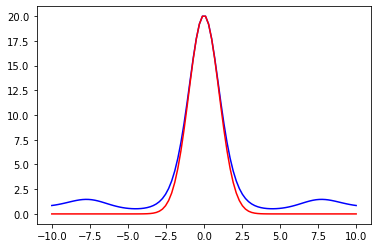

In [8]:
import matplotlib.pyplot as plt
xplt = np.linspace(-10, 10, 100)
true_f = np.exp(test_f(xplt))
quadratic = np.exp(f0 - 0.5 * np.abs(fdd0) * xplt ** 2)
plt.plot(xplt, true_f, 'b-')
plt.plot(xplt, quadratic, 'r-')
plt.show()

# INLA

In order to do a quadratic/gaussian approximation for Laplace approximation, we need derivatives of the joint density as a function of the latent variables.

In [9]:
grad_LD = sp.diff(full_LD, x)
hess_LD_ugly = sp.diff(grad_LD, x)
display(grad_LD)
display(hess_LD_ugly)

-Q*(-2*a + 2*x)/2 - n*exp(x)/(exp(x) + 1) + y

-Q - n*exp(x)/(exp(x) + 1) + n*exp(2*x)/(exp(x) + 1)**2

In [10]:
hess_LD = -Q - (n*sp.exp(x) / ((sp.exp(x) + 1) ** 2))
(hess_LD - hess_LD_ugly).simplify()

0

The above derivation is only correct for a problem with a single x. Extending by hand to the matrix setting:

\begin{align}
f(x) = \log p(x, y, \theta) \\
\nabla f(x) = vec \big[ y_i - \frac{n_ie^{x_i}}{e^{x_i} + 1}\big] - Q(x-a)\\
Hf(x) = -Q - diag \big[ \frac{n_i * e^{x_i}}{(e^{x_i} + 1)^2}]
\end{align}

Or more usefully from a code perspective, if the terms in $\log p(y | x, \theta)$ are separable and we drop terms that are constant in $x$:

\begin{align}
f(x) &= \log p(y | x, \theta) + \log p(x | \theta)\\
f(x) &= g(x, \theta) - \frac{1}{2} (x - a)^TQ(x - a)\\
\nabla f(x) &= vec \big[ \frac{dg(x_i)}{dx_i}\big] - Q(x-a)\\
Hf(x) &= diag \big[ \frac{d^2g(x_i)}{dx_i^2}\big] -Q
\end{align}
This is nice because it leaves the specification of the model transforming from $x_i$ to $y_i$ unspecified and flexible. 

# Replicating R-INLA results

## Joint density and its gradient and Hessian

Because each $x_i$ is an i.i.d. draw, we know that $Q$ is diagonal. That is, there is no interdependence between $x_i$ and $x_j$. 

In [59]:
import numpy as np
from IPython.display import display

n_i = np.full(4, 50)
x_i = np.array([0.0542217351633235, -0.7058565689642957, 0.5411263138456900, 1.1393884075711429])
p_i = np.array([0.5135521136895386, 0.3305150325484877, 0.6320743881220601, 0.7575673322021476])
y_i = np.array([28, 14, 33, 36])
rinla_cis = np.array([
    [-0.2914459, 0.7714731],
    [-1.399438, -0.1621846],
    [0.05145177, 1.165792],
    [0.2554444, 1.437953]
])

In [12]:
# Note that if you want to ignore the Q_det term, it's simple to do so by just
# setting it equal to one. Then, the log Q_det = 0. This can be nice for
# optimizing over x.
calc_log_joint_sp = sp.lambdify([x, y, n, a, Q, Qd], full_LD, 'numpy')
calc_log_joint_sp(x_i, y_i, n_i, 0, 1.0, 1)

array([-34.51453655, -30.19343709, -32.28296563, -30.48268359])

In [13]:
full_LD

-Q*(-a + x)**2/2 - n*log(exp(x) + 1) + x*y + log(Q_{det})/2

In [74]:
# Qv is the value on the precision matrix diagonal. We can either treat Qv as
# known and infer the x_i via what would seem to be a purely frequentist maximum
# likelihood estimation. Or we can treat Qv as drawn from a prior distribution
# and infer the posterior distribution of both x_i and Qv.
def calc_precision_matrixQ(Qv):
    return np.diag(np.full(x_i.shape[0], Qv))

def calc_log_joint(x, y, n, a, Q):
    term1 = -(x-a).T.dot(Q).dot(x-a) / 2
    term2 = np.sum(-n * np.log(np.exp(x) + 1))
    term3 = np.sum(x * y)
    term4 = np.log(np.linalg.det(Q)) / 2
    return term1 + term2 + term3 + term4

def calc_log_joint_xonly(x, y, n, a, Q):
    term1 = -(x-a).T.dot(Q).dot(x-a) / 2
    term2 = np.sum(-n * np.log(np.exp(x) + 1))
    term3 = np.sum(x * y)
    return term1 + term2 + term3

def calc_gradx_log_joint(x, y, n, a, Q):
    term1 = -Q.dot(x - a)
    term2 = -(n * np.exp(x) / (np.exp(x) + 1))
    term3 = y
    return term1 + term2 + term3

def calc_hessx_log_joint(x, y, n, a, Q):
    term1 = -np.diag(n * np.exp(x) / ((np.exp(x) + 1) ** 2) )
    term2 = -Q
    return term1 + term2

Let's check that gradient and hessian numerically.

In [75]:
Qv0 = 1.0 
Qmat = calc_precision_matrixQ(Qv0)
dx = 0.001

def calc_numerical_grad(local_x_i, row):
    dx_vec = np.zeros(4)
    dx_vec[row] = dx
    f0 = calc_log_joint_xonly(local_x_i-dx_vec, y_i, n_i, 0, Qmat)
    f2 = calc_log_joint_xonly(local_x_i+dx_vec, y_i, n_i, 0, Qmat)
    return (f2 - f0) / (2*dx)

num_grad = np.empty(4)
for i in range(4):
    num_grad[i] = calc_numerical_grad(x_i, i)
analytical_grad = calc_gradx_log_joint(x_i, y_i, n_i, 0, Qmat)
num_grad, analytical_grad

(array([ 2.26817264, -1.81989568,  0.85515479, -3.01775423]),
 array([ 2.26817258, -1.81989506,  0.85515428, -3.01775502]))

In [76]:

num_hess = np.empty((4, 4))
for i in range(4):
    for j in range(4):
        dx_vec = np.zeros(4)
        dx_vec[j] = dx
        g0 = calc_numerical_grad(x_i + dx_vec, i)
        g2 = calc_numerical_grad(x_i - dx_vec, i)
        num_hess[i, j] = (g2 - g0) / (2*dx)
np.set_printoptions(linewidth=100)
analytical_hess = calc_hessx_log_joint(x_i, y_i, n_i, a, Qmat)
num_hess, analytical_hess

(array([[ 1.34908149e+01,  1.06581410e-08,  7.10542736e-09, -3.55271368e-09],
        [ 1.06581410e-08,  1.20637411e+01,  7.10542736e-09, -1.42108547e-08],
        [ 7.10542736e-09,  7.10542736e-09,  1.26278163e+01,  0.00000000e+00],
        [-3.55271368e-09, -1.42108547e-08,  0.00000000e+00,  1.01829532e+01]]),
 array([[-13.49081701,  -0.        ,  -0.        ,  -0.        ],
        [ -0.        , -12.06374229,  -0.        ,  -0.        ],
        [ -0.        ,  -0.        , -12.6278178 ,  -0.        ],
        [ -0.        ,  -0.        ,  -0.        , -10.18295347]]))

Great! Looks good.

## Finding the maximum of the joint density as a function of $x$


In [77]:
import scipy.optimize
# Remember that x_i is unknown here since we only observe y_i and n_i. a and Qmat are assumed.
def calc_x0_brute(av, Qmat):
    return scipy.optimize.minimize(
        lambda xvec: -calc_log_joint_xonly(xvec, y_i, n_i, av, Qmat),
        np.zeros_like(y_i),
        jac=lambda xvec: -calc_gradx_log_joint(xvec, y_i, n_i, av, Qmat),
        method='BFGS'
        # hess=lambda xvec: calc_hessx_log_joint(xvec, y_i, n_i, 0, Qmat),
        # method='Newton-CG'
    )
x_max = calc_x0_brute(0, Qmat)
x_max

      fun: 126.68495015271003
 hess_inv: array([[ 7.46684737e-02,  8.20472524e-06, -3.33556526e-04, -8.20472476e-06],
       [ 8.20472524e-06,  5.43733039e-01,  1.07414737e-05,  4.56266961e-01],
       [-3.33556526e-04,  1.07414737e-05,  8.01735214e-02, -1.07414740e-05],
       [-8.20472476e-06,  4.56266961e-01, -1.07414740e-05,  5.43733039e-01]])
      jac: array([ 2.53185274e-06,  9.17296251e-06,  3.00222933e-06, -9.17296159e-06])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([ 0.22307471, -0.86060795,  0.6094328 ,  0.86060795])

I *think* that this is the maximum likelihood estimate for $x$. In which case it should track somewhat with the true `x_i` array. And it does.

In [78]:
x_i, y_i

(array([ 0.05422174, -0.70585657,  0.54112631,  1.13938841]),
 array([28, 14, 33, 36]))

In [79]:
gradx_max = calc_gradx_log_joint(x_max['x'], y_i, n_i, 0, Qmat)
np.testing.assert_allclose(gradx_max, 0, atol=1e-5)
gradx_max

array([-2.53185274e-06, -9.17296251e-06, -3.00222933e-06,  9.17296159e-06])

In [80]:
hessx_max = calc_hessx_log_joint(x_max['x'], y_i, n_i, 0, Qmat)
hessx_max

array([[-13.34577344,  -0.        ,  -0.        ,  -0.        ],
       [ -0.        , -11.4438583 ,  -0.        ,  -0.        ],
       [ -0.        ,  -0.        , -12.40758944,  -0.        ],
       [ -0.        ,  -0.        ,  -0.        , -11.4438583 ]])

## Quadratic approximation of the log density

In [81]:
def appx_density(pts, x0, fx0):
    hessx_max = calc_hessx_log_joint(x0, y_i, n_i, 0, Qmat)
    x_deviation = pts - x0
    return -fx0 + 0.5 * np.sum(x_deviation.dot(hessx_max) * x_deviation, axis=1)

pltx = np.linspace(x_max['x'][0] - 1, x_max['x'][0] + 1, 50)
plty = np.linspace(x_max['x'][1] - 1, x_max['x'][1] + 1, 50)
pltX, pltY = np.meshgrid(pltx, plty)
plt_pts = np.stack((pltX, pltY), axis=2).reshape((-1, 2))
plt_pts_full = np.empty((plt_pts.shape[0], 4))
plt_pts_full[:, :2] = plt_pts
plt_pts_full[:, 2:] = x_max['x'][2:]
density = np.array([calc_log_joint_xonly(plt_pts_full[i], y_i[None,None,:], n_i[None,None,:], 0, Qmat) for i in range(plt_pts_full.shape[0])])

x_deviation = (plt_pts_full - x_max['x'])
density_quadratic = appx_density(plt_pts_full, x_max['x'], x_max['fun'])
error = density - density_quadratic

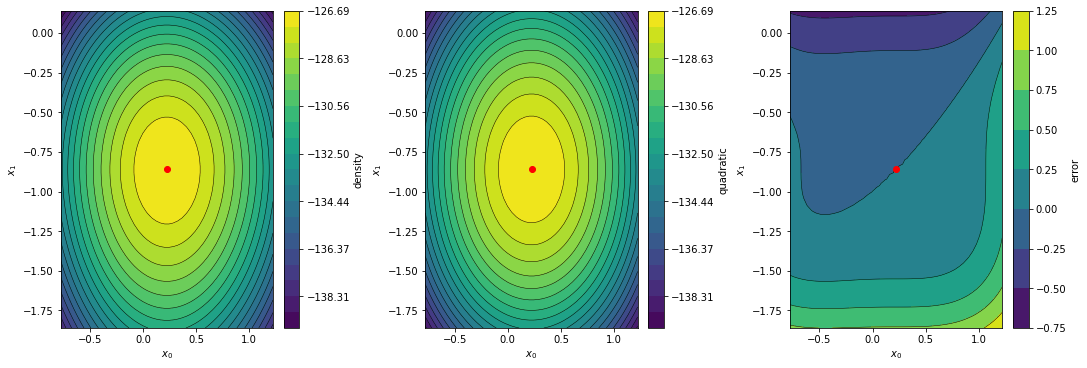

In [82]:
plt.figure(figsize=(15, 5), constrained_layout=True)
plt.subplot(1,3,1)
levels = np.linspace(np.min(density), np.max(density), 21)
cntf = plt.contourf(pltX, pltY, density.reshape(pltX.shape), levels=levels)
plt.contour(
    pltX, pltY, density.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('density')

plt.subplot(1,3,2)
cntf = plt.contourf(pltX, pltY, density_quadratic.reshape(pltX.shape), levels=levels)
plt.contour(
    pltX, pltY, density_quadratic.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('quadratic')

plt.subplot(1,3,3)
cntf = plt.contourf(pltX, pltY, error.reshape(pltX.shape))
plt.contour(
    pltX, pltY, error.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('error')


plt.show()

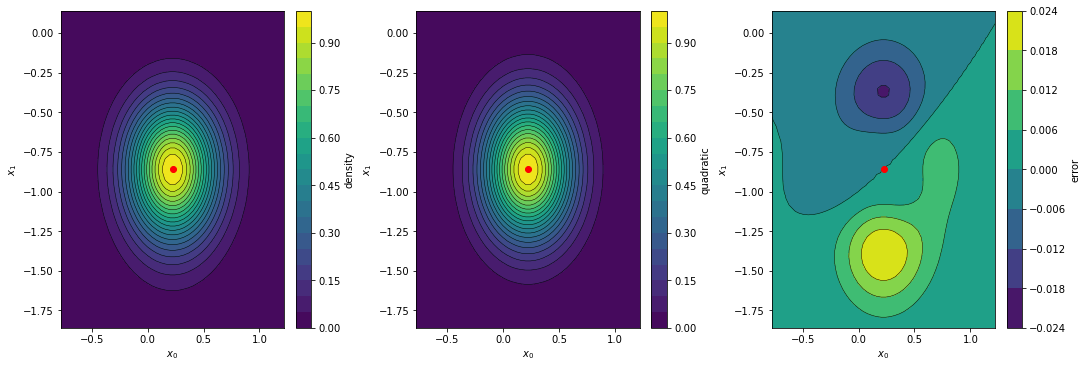

In [83]:
# Convert from log-p-space to p-space. I also offset since these are
# un-normalized and, in log space, any constant can be legally added or
# subtracted.
density_offset = np.max(density)
exp_density = np.exp(density - density_offset)
exp_density_quadratic = np.exp(density_quadratic - density_offset)
exp_error = exp_density - exp_density_quadratic

plt.figure(figsize=(15, 5), constrained_layout=True)
plt.subplot(1,3,1)
levels = np.linspace(np.min(exp_density), np.max(exp_density), 21)
cntf = plt.contourf(pltX, pltY, exp_density.reshape(pltX.shape), levels=levels)
plt.contour(
    pltX, pltY, exp_density.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('density')

plt.subplot(1,3,2)
cntf = plt.contourf(pltX, pltY, exp_density_quadratic.reshape(pltX.shape), levels=levels)
plt.contour(
    pltX, pltY, exp_density_quadratic.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('quadratic')

plt.subplot(1,3,3)
cntf = plt.contourf(pltX, pltY, exp_error.reshape(pltX.shape))
plt.contour(
    pltX, pltY, exp_error.reshape(pltX.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5
)
plt.plot([x_max['x'][0]], [x_max['x'][1]], 'ro')
cbar = plt.colorbar(cntf)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
cbar.set_label('error')


plt.show()

## Integrating

First, let's integrate the true joint density with a Gaussian quadrature rule. This is impractical for a larger problem, but it works just fine for a 4D problem. Then, we'll compare with the Laplace approximation integral.

In [84]:
quad_rule = quadpy.c1.gauss_legendre(10)
qgaussx, qgaussw = quad_rule.points, quad_rule.weights

qx0, qx1, qx2, qx3 = np.meshgrid(qgaussx, qgaussx, qgaussx, qgaussx)
qx = np.stack((qx0, qx1, qx2, qx3), axis=4).reshape((-1, 4))
qx += x_max['x']
qw = (
    qgaussw[None, None, None, :]
    * qgaussw[None, None, :, None]
    * qgaussw[None, :, None, None]
    * qgaussw[:, None, None, None]
).flatten()

In [85]:
np.min(qx, axis=0), np.max(qx, axis=0), np.sum(qw)

(array([-0.75083182, -1.83451448, -0.36447373, -0.11329858]),
 array([1.19698123, 0.11329858, 1.58333932, 1.83451448]),
 15.999999999999996)

In [86]:
density_qx = np.array([np.exp(calc_log_joint_xonly(qx[i], y_i, n_i, 0, Qmat)) for i in range(qx.shape[0])])
gauss_I = np.sum(qw * density_qx)
laplace_I = np.exp(-x_max['fun']) * ((2 * np.pi) ** (y_i.shape[0] / 2)) / np.sqrt(np.linalg.det(-hessx_max))
gauss_I, laplace_I

(2.609020057133258e-56, 2.568602449911287e-56)

**Dang**!!! Pretty good!!!

## Plotting a slice of $p(x|y,\theta)$

I'll plot for various values of $x_0$ while holding $x_{1..3}$ fixed and equal to the MLE estimate.

I'm a bit suspicious about some of this since I'm using a joint density function between all $x_{0..3}$ and then just normalizing the "cdf". I think this is wrong since I should be integrating out the other variables to get a marginal distribution for a single $x_j$. 

In [90]:
import scipy.integrate

for j in range(4):
    xj_vals = np.linspace(-2, 2, 200)
    x_vals = np.empty((200, 4))
    x_vals[:, :] = x_max['x']
    x_vals[:, j] = xj_vals
    density_xj = np.array([np.exp(calc_log_joint_xonly(x_vals[i], y_i, n_i, 0, Qmat)) for i in range(x_vals.shape[0])])
    scaled = density_xj / laplace_I
    # plt.plot(xj_vals, scaled)
    # plt.show()

    cdf = np.array([scipy.integrate.simpson(scaled[:i], xj_vals[:i]) for i in range(1, xj_vals.shape[0])])
    normalize = cdf[-1]
    cdf /= normalize

    # plt.plot(xj_vals[1:], cdf)
    # plt.show()
    ci = (xj_vals[np.argmax(cdf > 0.025) - 1], xj_vals[np.argmax(cdf > 0.975) + 1])
    print(f'x[{j}] ci here: {ci} \nr-inla ci: {rinla_cis[j]}  \ntrue val: {x_i[j]}\n')

x[0] ci here: (-0.31155778894472363, 0.7939698492462313) 
r-inla ci: [-0.2914459  0.7714731]  
true val: 0.0542217351633235

x[1] ci here: (-1.4974874371859297, -0.27135678391959805) 
r-inla ci: [-1.399438  -0.1621846]  
true val: -0.7058565689642957

x[2] ci here: (0.05025125628140703, 1.2160804020100504) 
r-inla ci: [0.05145177 1.165792  ]  
true val: 0.54112631384569

x[3] ci here: (0.29145728643216096, 1.4974874371859297) 
r-inla ci: [0.2554444 1.437953 ]  
true val: 1.139388407571143



## A better marginal distribution.